In [1]:
# Install required libs
!apt install -y libsm6 libxext6 libxrender-dev
### please update Albumentations to version>=0.3.0 for `Lambda` transform support
!pip install --upgrade pip
!pip install keras
!pip install opencv-python
!pip install albumentations
!pip install segmentation-models
!pip install tensorflow-gpu

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libbsd0 libice6 libpthread-stubs0-dev libx11-6 libx11-data libx11-dev
  libx11-doc libxau-dev libxau6 libxcb1 libxcb1-dev libxdmcp-dev libxdmcp6
  libxrender1 x11-common x11proto-core-dev x11proto-dev xorg-sgml-doctools
  xtrans-dev
Suggested packages:
  libxcb-doc
The following NEW packages will be installed:
  libbsd0 libice6 libpthread-stubs0-dev libsm6 libx11-6 libx11-data libx11-dev
  libx11-doc libxau-dev libxau6 libxcb1 libxcb1-dev libxdmcp-dev libxdmcp6
  libxext6 libxrender-dev libxrender1 x11-common x11proto-core-dev
  x11proto-dev xorg-sgml-doctools xtrans-dev
0 upgraded, 22 newly installed, 0 to remove and 8 not upgraded.
Need to get 4102 kB of archives.
After this operation, 19.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxau6 amd64 1:1.0.8-1 [8376 B]
Get:2 http://ar

7Progress: [ 29%] [################..........................................] 87Progress: [ 30%] [#################.........................................] 8Selecting previously unselected package xorg-sgml-doctools.
Preparing to unpack .../11-xorg-sgml-doctools_1%3a1.11-1_all.deb ...
7Progress: [ 31%] [#################.........................................] 8Unpacking xorg-sgml-doctools (1:1.11-1) ...
7Progress: [ 32%] [##################........................................] 87Progress: [ 32%] [##################........................................] 8Selecting previously unselected package x11proto-dev.
Preparing to unpack .../12-x11proto-dev_2018.4-4_all.deb ...
7Progress: [ 33%] [###################.......................................] 8Unpacking x11proto-dev (2018.4-4) ...
7Progress: [ 34%] [###################.......................................] 87Progress: [ 35%] [####################......................................] 8Selecting previous

7Progress: [ 78%] [#############################################.............] 87Progress: [ 79%] [#############################################.............] 8Setting up libxau-dev:amd64 (1:1.0.8-1) ...
7Progress: [ 80%] [##############################################............] 87Progress: [ 81%] [###############################################...........] 8Setting up libxdmcp-dev:amd64 (1:1.1.2-3) ...
7Progress: [ 83%] [################################################..........] 8Setting up libice6:amd64 (2:1.0.9-2) ...
7Progress: [ 84%] [################################################..........] 87Progress: [ 85%] [#################################################.........] 8Setting up libxcb1:amd64 (1.13-2~ubuntu18.04) ...
7Progress: [ 86%] [#################################################.........] 87Progress: [ 86%] [##################################################........] 8Setting up libsm6:amd64 (2:1.2.2-1) ...
7Progress: [ 87%] [#####################

  Created wheel for albumentations: filename=albumentations-0.4.5-py3-none-any.whl size=70248 sha256=1826d20b86fc20c89b5b262cf729bb737948c871279b91794665b49924ab84a5
  Stored in directory: /root/.cache/pip/wheels/78/d2/b4/617573279167b9cb8fd3a2d17923ae044d5d213bb552abc1be
  Created wheel for imgaug: filename=imgaug-0.2.6-py3-none-any.whl size=654972 sha256=053ed8dd911a3b41e830d8e3d0c820131fdfc5368ad4849cae3eca8701255009
  Stored in directory: /root/.cache/pip/wheels/ce/b4/ea/ed7e89421721d66834627a2983c5bc4ce298056d5d3f37049e
Successfully built albumentations imgaug


Code modified from: https://github.com/qubvel/segmentation_models/blob/master/examples/binary%20segmentation%20(camvid).ipynb

# Load Dataset

In [89]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

In [90]:
DATA_DIR = '/tf/data/dataset/'

In [91]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_annotation')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_annotation')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_annotation')

In [105]:
# helper function for data visualization
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):

    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    
    CLASSES = ['lesion']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        #print(self.images_fps[i])
        image = cv2.imread(self.images_fps[i])
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask
        masks = [(mask == v + 1) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    

# Class to create batches
class Dataloder(keras.utils.Sequence):
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

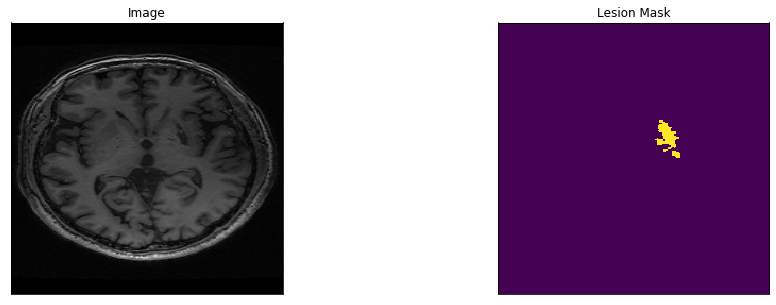

In [106]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['Lesion'])

image, mask = dataset[144] # get some sample
visualize(
    image=image, 
    lesion_mask=mask[..., 0].squeeze()
)

# Augmentation

In [107]:
import albumentations as A

In [109]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=256, min_width=256, always_apply=True, border_mode=0),
        A.RandomCrop(height=256, width=256, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [
        A.PadIfNeeded(256, 256)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

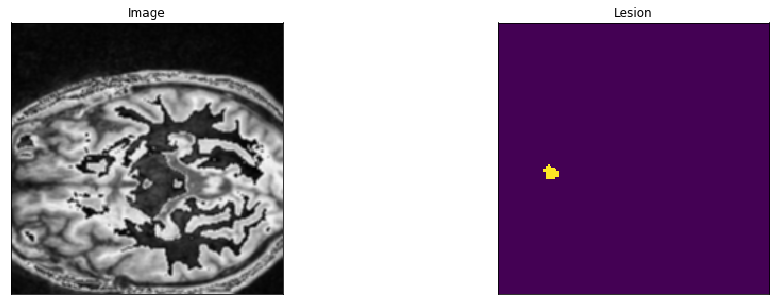

In [110]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['lesion'], augmentation=get_training_augmentation())

image, mask = dataset[12] # get some sample
visualize(
    image=image, 
    lesion=mask[..., 0].squeeze()
)

# Launch Training

In [97]:
import segmentation_models as sm

In [98]:
BACKBONE = 'resnet34'
BATCH_SIZE = 16
CLASSES = ['lesion']
LR = 0.0001
EPOCHS = 40

preprocess_input = sm.get_preprocessing(BACKBONE)

In [111]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights=None)

In [112]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [115]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 256, 256, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 256, 256, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [ ]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/40
919/919 [==============================] - 245s 267ms/step - loss: 0.7868 - iou_score: 0.1898 - f1-score: 0.3060 - val_loss: 0.9325 - val_iou_score: 0.1192 - val_f1-score: 0.1681
Epoch 2/40
919/919 [==============================] - 243s 265ms/step - loss: 0.5870 - iou_score: 0.3031 - f1-score: 0.4512 - val_loss: 0.8720 - val_iou_score: 0.1485 - val_f1-score: 0.1987
Epoch 3/40
919/919 [==============================] - 241s 262ms/step - loss: 0.5164 - iou_score: 0.3596 - f1-score: 0.5152 - val_loss: 0.4922 - val_iou_score: 0.1848 - val_f1-score: 0.2398
Epoch 4/40
919/919 [==============================] - 243s 265ms/step - loss: 0.4725 - iou_score: 0.3983 - f1-score: 0.5563 - val_loss: 0.2324 - val_iou_score: 0.1990 - val_f1-score: 0.2592
Epoch 5/40
919/919 [==============================] - 244s 265ms/step - loss: 0.4425 - iou_score: 0.4252 - f1-score: 0.5841 - val_loss: 0.5597 - val_iou_score: 0.1770 - val_f1-score: 0.2211
Epoch 6/40
919/919 [==============================

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.figure(figsize=(30, 5))
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_f1-score'])
plt.title('Model f1-score')
plt.ylabel('f1-score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(30, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Model Evaluation

In [ ]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [ ]:
# load best weights
model.load_weights('best_model.h5')

In [ ]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

# View Results

In [ ]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )
